In [1]:
!pip install transformers datasets diffusers[torch] matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 25.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms
import transformers, datasets, diffusers
from datasets import load_dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler


# tqdm.auto에서 tqdm 로딩하면 중간에 데이터로더가 멈춤, 기다리면 다시 시작되긴 함
# 데이터 로더와 tqdm 충돌 문제
# https://discuss.pytorch.org/t/exception-ignored-in-function-multiprocessingdataloaderiter-del-at/133498
# https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/14
# from tqdm.auto import tqdm
from tqdm import tqdm

from PIL import Image

In [5]:
transformers.__version__, datasets.__version__, diffusers.__version__

('4.53.2', '4.0.0', '0.34.0')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
dataset = load_dataset("json", data_files="car_image_text.json")

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 58
    })
})

In [12]:
idx = 20
dataset["train"][idx]["image"]

car_images_all/4_4_디_올_뉴_팰리세이드.png


In [10]:
PRE_TRAINED_MODEL_NAME="sd-legacy/stable-diffusion-v1-5"

noise_scheduler = DDPMScheduler.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="scheduler"
)

tokenizer = CLIPTokenizer.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="tokenizer"
)

# 학습 파라미터 있으나 고정될 것임
text_encoder = CLIPTextModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="text_encoder"
)

# 학습 파라미터 있으나 고정될 것임
vae = AutoencoderKL.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="vae"
)

# 학습 파라미터 있고 파인튜닝 될 것임
unet = UNet2DConditionModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="unet"
)

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [13]:
# 모델에 입력되는 최대 토큰 길이
tokenizer.model_max_length

77

In [14]:
# 토크나이징 테스트
tokenizer(dataset['train'][idx]['text'],
          max_length=tokenizer.model_max_length,
          padding='max_length',
          truncation=True,
          return_tensors='pt')

{'input_ids': tensor([[49406,   589,  1615,  4643,   320,  4077, 15985,  1774,  3877,   593,
           320, 15273,   267, 44363,   943, 35775,   269,   518,  7744,   533,
         23187,   593,  8990,   267, 14922,  3418,   269,   585,   791,  8859,
          5799,   593, 16652,   267, 12797,   912, 19000,   269,   518,  9519,
           533, 16536,   537, 25775,   267, 34307,   593,   518,  2184,  1681,
           269,   518,  8025,   631,  3638,   593,   320,  6400,   268,  6518,
         22467,  7447,   269,   518,  3140,   533,   320, 20833,  3144,  1901,
           269,  1107,  2319, 10925,  5942,   518, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

In [15]:
def tokenize_captions(examples, caption_column='text', is_train=True):
    captions = []

    for caption in examples[caption_column]:
        # 캡션이 하나인 경우
        if isinstance(caption, str):
            captions.append(caption)
        # 캡션이 하나 이상인 경우 아무거나 하나 선택
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )

    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )

    return inputs.input_ids

In [17]:
IMG_SIZE = 512
CENTER_CROP = True
RANDOM_FLIP = True

# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

100%|██████████| 50/50 [00:01<00:00, 27.44it/s]


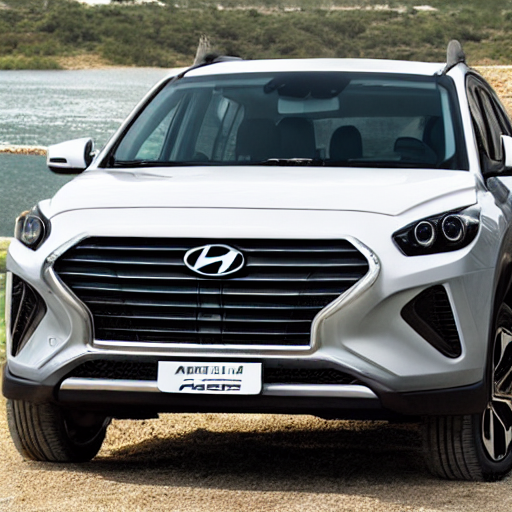

In [14]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe_ori = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = "Front of SUV designed by Hyundai"
image_ori = pipe_ori(prompt).images[0]
image_ori

100%|██████████| 50/50 [00:02<00:00, 22.66it/s]


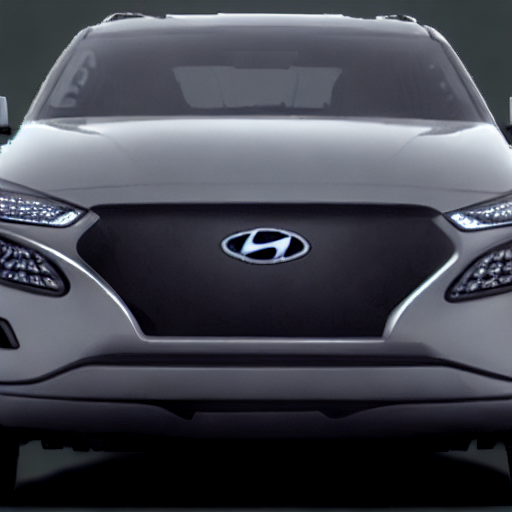

In [13]:
from diffusers import StableDiffusionPipeline
import torch
from peft import PeftModel, PeftConfig

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe_fine = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

# LoRA weight 적용
pipe_fine.unet.load_attn_procs("lora_hyundai_output/checkpoint-800")  # 혹은 checkpoint-1000 디렉토리

image_fine = pipe_fine("Front of SUV designed by Hyundai").images[0]
image_fine
# image.save("output.png")

In [2]:
!pip install --upgrade python-dotenv 


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!pip install dotenv

  Using cached dotenv-0.9.9-py2.py3-none-any.whl.metadata (279 bytes)
Using cached dotenv-0.9.9-py2.py3-none-any.whl (1.9 kB)

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
!pip uninstall -y dotenv

Found existing installation: dotenv 0.9.9
Uninstalling dotenv-0.9.9:
  Successfully uninstalled dotenv-0.9.9


In [8]:
!pip list

Package                           Version
--------------------------------- -------------
anyio                             4.0.0
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         2.4.1
async-lru                         2.0.4
attrs                             23.1.0
Babel                             2.13.1
beautifulsoup4                    4.12.2
bleach                            6.1.0
blinker                           1.4
certifi                           2022.12.7
cffi                              1.16.0
charset-normalizer                2.1.1
comm                              0.2.0
cryptography                      3.4.8
dbus-python                       1.2.18
debugpy                           1.8.0
decorator                         5.1.1
defusedxml                        0.7.1
distro                            1.7.0
entrypoints                       0.4
exceptiongroup         

In [15]:
from huggingface_hub import login

login("")

ValueError: Token SKN13 not found in /root/.cache/huggingface/stored_tokens

In [7]:
!huggingface-cli repo create lora-hyundai-sd15 --type=model

/bin/bash: line 1: huggingface-cli: command not found


In [8]:
import json
config = {
    "r": 4,
    "lora_alpha": 16,
    "lora_dropout": 0.0,
    "bias": "none",
    "task_type": "UNET"
}
with open("lora_hyundai_output/adapter_config.json", "w") as f:
    json.dump(config, f, indent=4)


In [10]:
from huggingface_hub import create_repo, upload_folder

upload_folder(
    repo_id="mingyu-oo/lora-hyundai-sd15",
    folder_path="./lora_hyundai_output",  # LoRA weight가 있는 디렉토리
    repo_type="model"
)

CommitInfo(commit_url='https://huggingface.co/mingyu-oo/lora-hyundai-sd15/commit/5553542b60cc5f478e196798e9d68b1607d1bc43', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5553542b60cc5f478e196798e9d68b1607d1bc43', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mingyu-oo/lora-hyundai-sd15', endpoint='https://huggingface.co', repo_type='model', repo_id='mingyu-oo/lora-hyundai-sd15'), pr_revision=None, pr_num=None)